# Lake model continued

In the previous week you used the lake problem as a means of getting aquinted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of [this tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the seperate anthropogenic release decision**

## Apply scenario discovery

1. Generate 10 policies and 1000 scenarios and evaluate them.
2. The experiments array contains the values for each of the 100 decision levers. This might easily mess up the analysis. Remove these columns from the experiment array. *hint: use `experiments.drop`*
3. Apply scenario discovery, focussing on the 10 percent of worst outcomes for reliability


In [1]:
from lakemodel_function import lake_problem

from ema_workbench import Model, RealParameter, ScalarOutcome, SequentialEvaluator, IpyparallelEvaluator, ema_logging, perform_experiments, MultiprocessingEvaluator

#instantiate the model
lake_model = Model('lakeproblem', function=lake_problem)
lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_model.levers = [RealParameter(f"l{i}", 0, 0.1) for i in 
                     range(lake_model.time_horizon)] # we use time_horizon here

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P'),
                       ScalarOutcome('utility'),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability')]

In [2]:
from ema_workbench import Policy, perform_experiments
from ema_workbench import ema_logging

ema_logging.log_to_stderr(ema_logging.INFO)

n_scenarios = 1000
n_policies = 10
from ema_workbench import MultiprocessingEvaluator

with MultiprocessingEvaluator(lake_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, n_policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [3]:
import pandas as pd
experiments, outcomes = results
policies = experiments['policy']

data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies

In [4]:
experiments.head()

,b,delta,mean,q,stdev,l0,l1,l10,l11,l12,...,l93,l94,l95,l96,l97,l98,l99,scenario,policy,model
0,0.146805,0.972522,0.039112,4.005078,0.003326,0.043728,0.054862,0.017205,0.004525,0.035233,...,0.081239,0.051049,0.046337,0.075191,0.075821,0.072846,0.004428,0,0,lakeproblem
1,0.103350,0.931856,0.046449,3.090498,0.001546,0.043728,0.054862,0.017205,0.004525,0.035233,...,0.081239,0.051049,0.046337,0.075191,0.075821,0.072846,0.004428,1,0,lakeproblem
2,0.449146,0.981559,0.011879,4.393807,0.002039,0.043728,0.054862,0.017205,0.004525,0.035233,...,0.081239,0.051049,0.046337,0.075191,0.075821,0.072846,0.004428,2,0,lakeproblem
3,0.129377,0.980613,0.042018,2.113297,0.003858,0.043728,0.054862,0.017205,0.004525,0.035233,...,0.081239,0.051049,0.046337,0.075191,0.075821,0.072846,0.004428,3,0,lakeproblem
4,0.372791,0.958880,0.038836,3.671915,0.001986,0.043728,0.054862,0.017205,0.004525,0.035233,...,0.081239,0.051049,0.046337,0.075191,0.075821,0.072846,0.004428,4,0,lakeproblem


In [5]:
exp_cleaned = experiments.drop(experiments.iloc[:, 5:-3], axis=1)
exp_cleaned.head()

,b,delta,mean,q,stdev,scenario,policy,model
0,0.146805,0.972522,0.039112,4.005078,0.003326,0,0,lakeproblem
1,0.103350,0.931856,0.046449,3.090498,0.001546,1,0,lakeproblem
2,0.449146,0.981559,0.011879,4.393807,0.002039,2,0,lakeproblem
3,0.129377,0.980613,0.042018,2.113297,0.003858,3,0,lakeproblem
4,0.372791,0.958880,0.038836,3.671915,0.001986,4,0,lakeproblem


In [6]:
#scenario discovery
from ema_workbench.analysis import prim
import numpy as np

x = exp_cleaned
y = outcomes['reliability'] < np.percentile(outcomes['reliability'], 10)

prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 10000 points remaining, containing 1000 cases of interest
[MainProcess/INFO] mean: 0.803921568627451, mass: 0.051, coverage: 0.41, density: 0.803921568627451 restricted_dimensions: 3


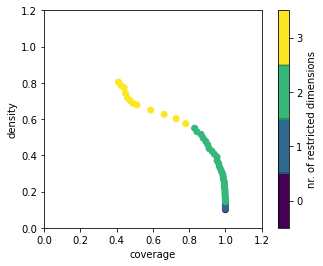

In [7]:
import matplotlib.pyplot as plt
box1.show_tradeoff()
plt.show()

coverage       0.988
density     0.279887
id                20
mass           0.353
mean        0.279887
res_dim            2
Name: 20, dtype: object

     box 20                                         
        min       max                      qp values
b  0.100340  0.300940  [-1.0, 1.642235557370602e-72]
q  2.000494  3.559909  [-1.0, 2.890092393065672e-56]



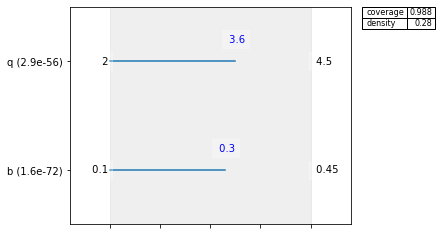

In [8]:
#inspect individual point
box1.inspect(20)
box1.inspect(20, style='graph')
plt.show()

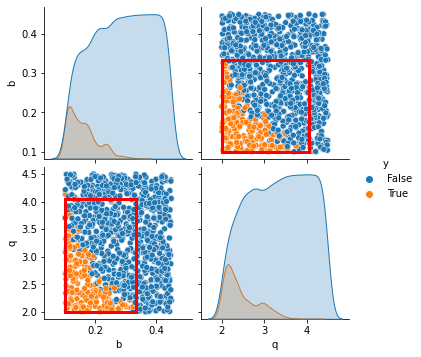

In [9]:
box1.show_pairs_scatter(12)
plt.show()

## Visualize the results using Dimensional Stacking
Take the classification of outcomes as used in step 3 of scenario discovery, and instead visualize the results using dimensional stacking. How do these results compare to the insights from scenario discovery?

In [22]:
outcomes_array = pd.DataFrame(outcomes)

outcomes_cleaned = outcomes_array[outcomes_array.reliability < np.percentile(outcomes['reliability'], 10)]
outcomes_cleaned


,max_P,utility,inertia,reliability
1,10.738125,0.289891,0.545455,0.0400
3,8.482095,0.874784,0.545455,0.0200
6,5.464744,0.387904,0.545455,0.0500
20,4.492627,0.880637,0.545455,0.0500
25,10.331314,1.095430,0.545455,0.0200
...,...,...,...,...
9960,9.669811,1.072179,0.656566,0.0200
9961,9.727038,0.958447,0.656566,0.0400
9962,10.162032,0.322114,0.656566,0.0400
9980,4.702203,0.387209,0.656566,0.0400


In [30]:
exp_cleaned

,b,delta,mean,q,stdev,policy,model
0,0.146805,0.972522,0.039112,4.005078,0.003326,0,lakeproblem
1,0.103350,0.931856,0.046449,3.090498,0.001546,0,lakeproblem
2,0.449146,0.981559,0.011879,4.393807,0.002039,0,lakeproblem
3,0.129377,0.980613,0.042018,2.113297,0.003858,0,lakeproblem
4,0.372791,0.958880,0.038836,3.671915,0.001986,0,lakeproblem
...,...,...,...,...,...,...,...
9995,0.222970,0.952281,0.030187,3.624919,0.001473,9,lakeproblem
9996,0.387185,0.950531,0.017158,3.029545,0.003856,9,lakeproblem
9997,0.312492,0.936323,0.036775,3.529607,0.003523,9,lakeproblem
9998,0.242433,0.964482,0.048895,3.387336,0.003341,9,lakeproblem


In [32]:
exp_test = exp_cleaned[exp_cleaned.index.isin(outcomes_cleaned.index)]
exp_test

,b,delta,mean,q,stdev,policy,model
1,0.103350,0.931856,0.046449,3.090498,0.001546,0,lakeproblem
3,0.129377,0.980613,0.042018,2.113297,0.003858,0,lakeproblem
6,0.198073,0.950106,0.027665,2.387139,0.004016,0,lakeproblem
20,0.244277,0.980795,0.044716,2.522224,0.002772,0,lakeproblem
25,0.105240,0.986421,0.031813,2.030124,0.001953,0,lakeproblem
...,...,...,...,...,...,...,...
9960,0.111479,0.985657,0.029664,2.147969,0.003993,9,lakeproblem
9961,0.112158,0.982583,0.035328,3.377744,0.001029,9,lakeproblem
9962,0.108449,0.933037,0.046528,3.554236,0.004589,9,lakeproblem
9980,0.227018,0.945624,0.029427,2.268886,0.001158,9,lakeproblem


In [25]:
outcomes_new = outcomes_cleaned.to_dict(orient = 'list')

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


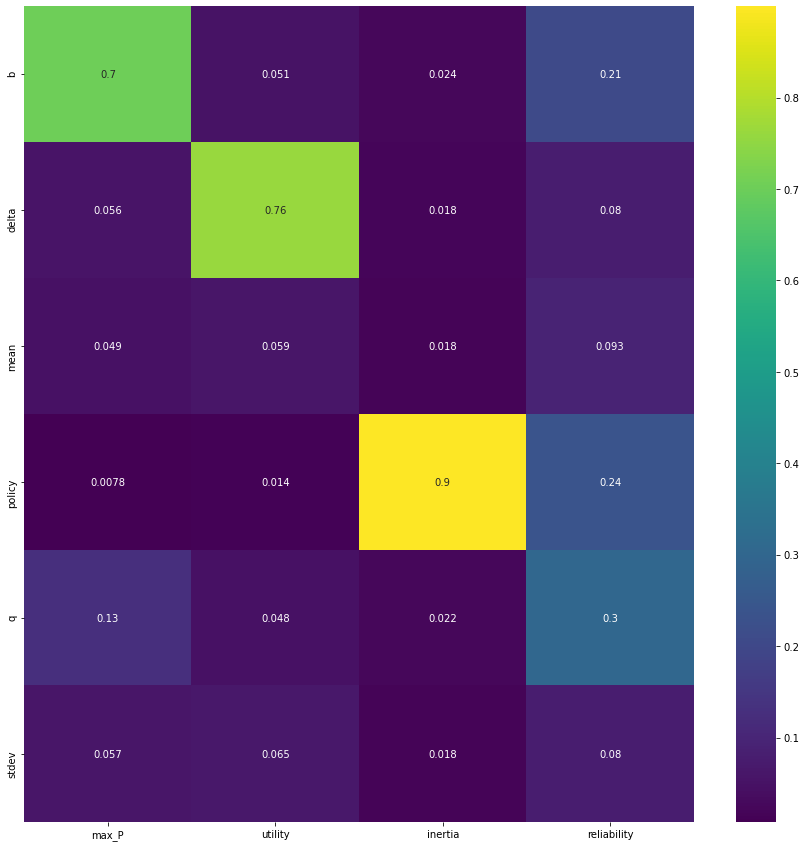

In [33]:
#visually identify the uncertainties that drive system behaviour
import seaborn as sns

from ema_workbench.analysis import feature_scoring
 
x = exp_test
y = outcomes_new #['reliability'] #< np.percentile(outcomes['reliability'], 10)
        

plt.figure(figsize=(15,15))
fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap='viridis', annot=True)
plt.show()